In [27]:
import pandas as pd
import numpy as np
from scipy import stats

In [28]:
df = pd.read_csv('data_vix_publication_signals.csv')
# Set Date as index
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)
print(df.head())

            Close   Contract  Year ContractSymbol_x ContractSymbol1  \
Date                                                                  
2014-01-24  16.21  CFE_VX_G4  2014            VX/G4      VX/G4_2014   
2014-01-27  16.09  CFE_VX_G4  2014            VX/G4      VX/G4_2014   
2014-01-28  15.19  CFE_VX_G4  2014            VX/G4      VX/G4_2014   
2014-01-29  16.40  CFE_VX_G4  2014            VX/G4      VX/G4_2014   
2014-01-30  16.65  CFE_VX_G4  2014            VX/G4      VX/G4_2014   

           ContractSymbol_y  Expiration  SettlementPrice  DaysToExpiry  \
Date                                                                     
2014-01-24       VX/G4_2014  19/02/2014            15.47            26   
2014-01-27       VX/G4_2014  19/02/2014            15.47            23   
2014-01-28       VX/G4_2014  19/02/2014            15.47            22   
2014-01-29       VX/G4_2014  19/02/2014            15.47            21   
2014-01-30       VX/G4_2014  19/02/2014            15.47  

C:\Users\annpe\AppData\Local\Temp\ipykernel_18412\2548868092.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df.index = pd.to_datetime(df.index)


In [29]:

# Majority vote (two strategies → if both agree → use that direction, else neutral)
df['Signal_ensemble'] = np.where(df['7input_standrd_sc_madl'] + df['7input_standrd_sc_custom_correct'] > 0, 1,
                          np.where(df['7input_standrd_sc_madl'] + df['7input_standrd_sc_custom_correct'] < 0, -1, -1))



In [30]:
def run_multiple_equity_strategies(df, signal_cols=None, dfl=0.25, initial_equity=1000):
    """
    Run equity strategies for multiple trading signals, plus always-long and always-short baselines.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing 'Close', 'SettlementPrice', 'DaysToExpiry', and signal columns (with values -1 / +1).
    signal_cols : list of str, optional
        List of signal column names. If None, automatically detects columns with "signal" (case-insensitive)
        or columns that look like signal outputs (e.g., contain 'input' and have numeric {-1, 1} values).
    dfl : float
        Directional leverage factor.
    initial_equity : float
        Starting equity for each strategy.

    Returns
    -------
    pd.DataFrame
        Original DataFrame plus new equity columns for each strategy.
    """

    df = df.copy()

    # Auto-detect signal columns if not provided
    if signal_cols is None:
        possible_signals = [
            col for col in df.columns
            if any(key in col.lower() for key in ['signal', 'input'])
            and df[col].dropna().isin([-1, 1]).any()
        ]
        signal_cols = sorted(possible_signals)
        print(f"Detected signal columns: {signal_cols}")

    # --- Equity simulation for each signal column ---
    for col in signal_cols:
        equity_col = f'Equity_{col}'
        df[equity_col] = initial_equity

        for t in range(1, len(df)):
            prev_idx, curr_idx = df.index[t - 1], df.index[t]

            prev_close = df.loc[prev_idx, 'Close']
            curr_close = df.loc[curr_idx, 'Close']
            prev_settlement = df.loc[prev_idx, 'SettlementPrice']
            prev_dte = df.loc[prev_idx, 'DaysToExpiry']
            signal = df.loc[prev_idx, col]
            prev_equity = df.loc[prev_idx, equity_col]

            if prev_dte > 1:
                ret = (curr_close / prev_close) - 1
            else:
                ret = (prev_settlement / prev_close) - 1

            df.loc[curr_idx, equity_col] = prev_equity * (1 + dfl * signal * ret)

    # --- Always Long / Always Short strategies ---
    df['Equity_Always_Long'] = initial_equity
    df['Equity_Always_Short'] = initial_equity

    for t in range(1, len(df)):
        prev_idx, curr_idx = df.index[t - 1], df.index[t]
        prev_close = df.loc[prev_idx, 'Close']
        curr_close = df.loc[curr_idx, 'Close']
        prev_settlement = df.loc[prev_idx, 'SettlementPrice']
        prev_dte = df.loc[prev_idx, 'DaysToExpiry']

        if prev_dte > 1:
            ret = (curr_close / prev_close) - 1
        else:
            ret = (prev_settlement / prev_close) - 1

        df.loc[curr_idx, 'Equity_Always_Long'] = df.loc[prev_idx, 'Equity_Always_Long'] * (1 + dfl * 1 * ret)
        df.loc[curr_idx, 'Equity_Always_Short'] = df.loc[prev_idx, 'Equity_Always_Short'] * (1 + dfl * -1 * ret)

    return df


In [31]:
def run_multiple_equity_strategies_with_cost(df, signal_cols=None, dfl=0.25, initial_equity=1000, transaction_cost=0.001):
    """
    Run equity strategies (one per signal column) plus always-long and always-short baselines.
    Includes transaction costs proportional to position changes.

    Parameters
    ----------
    df : pd.DataFrame
        Must include: ['Close', 'SettlementPrice', 'DaysToExpiry'] and signal columns with {-1, 1}.
    signal_cols : list of str, optional
        List of column names for trading signals.
        If None -> automatically detects columns that look like signals (e.g., contain 'signal' or 'input' and have -1/+1).
    dfl : float
        Directional leverage factor.
    initial_equity : float
        Starting equity for each strategy.
    transaction_cost : float
        Cost per unit turnover (e.g., 0.001 = 0.1%).

    Returns
    -------
    pd.DataFrame
        DataFrame with added equity columns for each signal and for always-long/short baselines.
    """

    df = df.copy()

    # --- Automatically detect signal columns ---
    if signal_cols is None:
        possible_signals = [
            col for col in df.columns
            if any(key in col.lower() for key in ['signal', 'input'])
            and df[col].dropna().isin([-1, 1]).any()
        ]
        signal_cols = sorted(possible_signals)
        print(f"Detected signal columns: {signal_cols}")

    # --- Simulate each strategy ---
    for col in signal_cols:
        equity_col = f'Equity_{col}'
        df[equity_col] = initial_equity

        for t in range(1, len(df)):
            prev_idx, curr_idx = df.index[t - 1], df.index[t]

            prev_close = df.loc[prev_idx, 'Close']
            curr_close = df.loc[curr_idx, 'Close']
            prev_settlement = df.loc[prev_idx, 'SettlementPrice']
            prev_dte = df.loc[prev_idx, 'DaysToExpiry']

            prev_signal = df.loc[prev_idx, col]
            curr_signal = df.loc[curr_idx, col]
            prev_equity = df.loc[prev_idx, equity_col]

            # Return depending on time to expiry
            if prev_dte > 1:
                ret = (curr_close / prev_close) - 1
            else:
                ret = (prev_settlement / prev_close) - 1

            # Turnover (absolute signal change)
            turnover = abs(curr_signal - prev_signal)

            # Transaction cost
            cost = prev_equity * transaction_cost * turnover

            # Update equity
            equity_after_return = prev_equity * (1 + dfl * prev_signal * ret)
            df.loc[curr_idx, equity_col] = equity_after_return - cost

    # --- Always long (+1) and always short (-1) baseline strategies ---
    df['Equity_Always_Long'] = initial_equity
    df['Equity_Always_Short'] = initial_equity

    for t in range(1, len(df)):
        prev_idx, curr_idx = df.index[t - 1], df.index[t]
        prev_close = df.loc[prev_idx, 'Close']
        curr_close = df.loc[curr_idx, 'Close']
        prev_settlement = df.loc[prev_idx, 'SettlementPrice']
        prev_dte = df.loc[prev_idx, 'DaysToExpiry']

        if prev_dte > 1:
            ret = (curr_close / prev_close) - 1
        else:
            ret = (prev_settlement / prev_close) - 1

        # Always long
        prev_equity_long = df.loc[prev_idx, 'Equity_Always_Long']
        df.loc[curr_idx, 'Equity_Always_Long'] = prev_equity_long * (1 + dfl * 1 * ret)

        # Always short
        prev_equity_short = df.loc[prev_idx, 'Equity_Always_Short']
        df.loc[curr_idx, 'Equity_Always_Short'] = prev_equity_short * (1 + dfl * -1 * ret)

    return df


In [32]:
df_with_equity = run_multiple_equity_strategies_with_cost(df)

Detected signal columns: ['7_inputs_minmax', '7_inputs_standard_sc', '7input_standrd_sc_custom_correct', '7input_standrd_sc_custom_loss', '7input_standrd_sc_gmadl, b=3', '7input_standrd_sc_gmadl, b=5', '7input_standrd_sc_madl', '7input_standrd_sc_mse/madl', 'LSTM_signal', 'SV_LSTM_signal', 'SV_signal', 'Signal_ensemble', 'baseline_monthly_input_stand_sc', 'baseline_vix_input_stand_sc']


C:\Users\annpe\AppData\Local\Temp\ipykernel_18412\2587070578.py:69: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1001.8507094386182' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[curr_idx, equity_col] = equity_after_return - cost
C:\Users\annpe\AppData\Local\Temp\ipykernel_18412\2587070578.py:69: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '999.8507094386182' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[curr_idx, equity_col] = equity_after_return - cost
C:\Users\annpe\AppData\Local\Temp\ipykernel_18412\2587070578.py:69: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1001.8507094386182' has dtype incompatible with int64, please explicitly cas

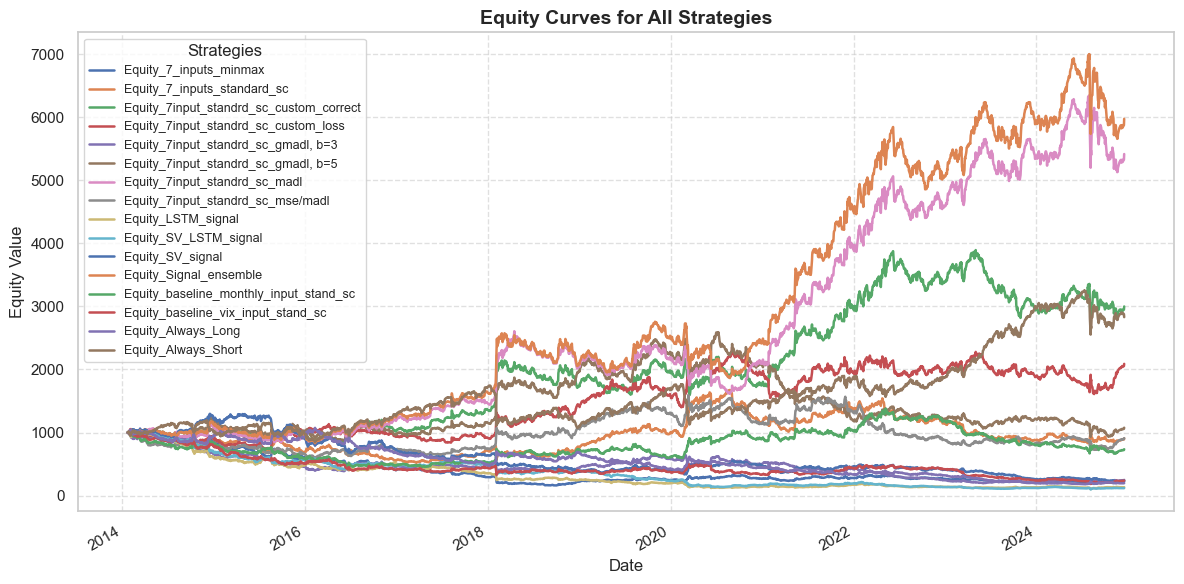

In [33]:
import matplotlib.pyplot as plt

# Select all columns that start with 'Equity_'
equity_cols = [col for col in df_with_equity.columns if col.startswith('Equity_')]

# Safety check (in case no equity columns found)
if not equity_cols:
    raise ValueError("No equity columns found in the DataFrame. Make sure to run the equity strategy function first.")

# Plot all equity lines
df_with_equity[equity_cols].plot(figsize=(12, 6), linewidth=1.8)
plt.title("Equity Curves for All Strategies", fontsize=14, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Equity Value")
plt.legend(title="Strategies", loc='upper left', fontsize=9)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_equity_strategies(df):
    """
    Plot 5 equity strategy curves from the DataFrame with a clean style.
    Assumes equity columns are named:
        'Equity_SV_signal', 'Equity_LSTM_signal', 'Equity_SV_LSTM_signal',
        'Equity_Always_Long', 'Equity_Always_Short'
    """

    plt.figure(figsize=(12, 6))
    sns.set(style="whitegrid")

    # Plot with labels, colors, and styles
    plt.plot(df.index, df['Equity_SV_signal'], label='SV Signal Strategy', color="navy", linewidth=1.0)
    plt.plot(df.index, df['Equity_LSTM_signal'], label='LSTM Signal Strategy', color="darkorange", linewidth=1.0)
    plt.plot(df.index, df['Equity_SV_LSTM_signal'], label='SV-LSTM Hybrid Strategy', color="darkviolet",linewidth=1.0)
    plt.plot(df.index, df['Equity_Always_Long'], label='Naive Long', color="g", linewidth=1.0)
    plt.plot(df.index, df['Equity_Always_Short'], label='Naive Short', color="crimson", linewidth=1.0)

    # Formatting
    plt.title('Equity Curve Comparison of Strategies', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Equity Value', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(loc='upper left', frameon=True)
    plt.tight_layout()

    plt.show()

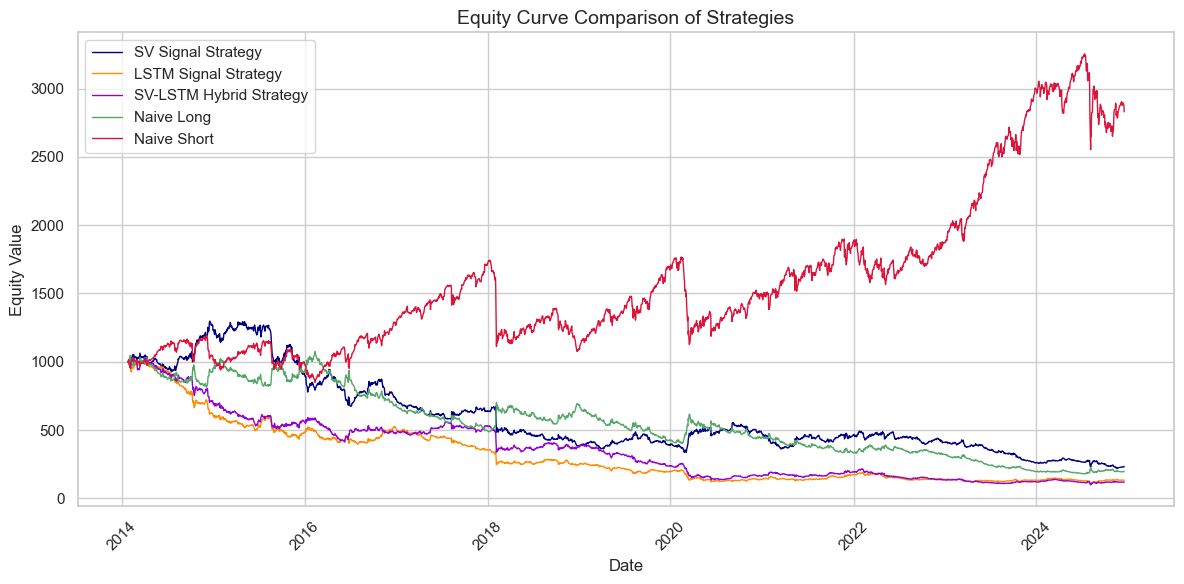

In [35]:
plot_equity_strategies(df_with_equity)

In [36]:
def calculate_metrics(df, equity_cols, benchmark_col='Equity_Always_Long', trading_days=252):
    results = {}

    for col in equity_cols:
        equity = df[col].dropna()
        returns = equity.pct_change().dropna()

        total_periods = len(returns)
        total_years = total_periods / trading_days
        annualized_return = (equity.iloc[-1] / equity.iloc[0]) ** (1 / total_years) - 1
        annualized_std = returns.std() * np.sqrt(trading_days)
        sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(trading_days)
        running_max = equity.cummax()
        drawdowns = (equity - running_max) / running_max
        max_drawdown = drawdowns.min()
        calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else np.nan

        # Information Ratio calculation
        if col == benchmark_col:
            information_ratio = np.nan  # or 0, depending on your preference
        else:
            benchmark_equity = df[benchmark_col].dropna()
            benchmark_returns = benchmark_equity.pct_change().dropna()
            common_idx = returns.index.intersection(benchmark_returns.index)
            excess_returns = returns.loc[common_idx] - benchmark_returns.loc[common_idx]

            if excess_returns.std() > 0:
                information_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(trading_days)
            else:
                information_ratio = np.nan

        results[col] = {
            'Annualized Return (%)': annualized_return * 100,
            'Annualized Std Dev (%)': annualized_std * 100,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown (%)': max_drawdown * 100,
            'Calmar Ratio': calmar_ratio,
            'Information Ratio': information_ratio
        }

    return pd.DataFrame(results).T

In [37]:
# Example usage
equity_columns = ['Equity_SV_signal', 'Equity_LSTM_signal', 'Equity_SV_LSTM_signal', 'Equity_Always_Long', 'Equity_Always_Short']
metrics_df = calculate_metrics(df_with_equity, equity_columns)
print(metrics_df)

                       Annualized Return (%)  Annualized Std Dev (%)  \
Equity_SV_signal                  -12.490734               22.886942   
Equity_LSTM_signal                -16.878562               22.907751   
Equity_SV_LSTM_signal             -17.744012               22.879226   
Equity_Always_Long                -13.816038               22.961166   
Equity_Always_Short                10.029413               22.961166   

                       Sharpe Ratio  Max Drawdown (%)  Calmar Ratio  \
Equity_SV_signal          -0.464412        -83.107245     -0.150297   
Equity_LSTM_signal        -0.687736        -90.007303     -0.187524   
Equity_SV_LSTM_signal     -0.734800        -90.356530     -0.196378   
Equity_Always_Long        -0.536248        -83.352424     -0.165754   
Equity_Always_Short        0.536248        -38.274361      0.262040   

                       Information Ratio  
Equity_SV_signal                0.047323  
Equity_LSTM_signal             -0.088180  
Equity_SV_L

In [38]:
import numpy as np
import pandas as pd

def calculate_metrics(df, equity_cols=None, benchmark_col='Equity_Always_Long', trading_days=252):
    # Automatically detect all equity columns if not provided
    if equity_cols is None:
        equity_cols = [col for col in df.columns if col.startswith('Equity_')]

    results = {}

    for col in equity_cols:
        equity = df[col].dropna()
        if len(equity) < 2:
            continue  # skip empty or too short columns

        # --- Returns and periods ---
        returns = equity.pct_change().dropna()
        total_periods = len(returns)
        total_years = total_periods / trading_days

        # --- Core performance metrics ---
        total_return = (equity.iloc[-1] / equity.iloc[0]) - 1
        ARC = (equity.iloc[-1] / equity.iloc[0]) ** (1 / total_years) - 1                # Annualized Return (Compound)
        ASD = returns.std() * np.sqrt(trading_days)                                      # Annualized Std Dev
        Sharpe = (returns.mean() / returns.std()) * np.sqrt(trading_days) if returns.std() > 0 else np.nan

        # --- Max Drawdown ---
        running_max = equity.cummax()
        drawdowns = (equity - running_max) / running_max
        MaxDD = drawdowns.min() * 100  # percentage

        # --- Information Ratios ---
        if col == benchmark_col:
            IR_star = np.nan   # IR* = relative to benchmark, skip for benchmark itself
            IR_star_star = np.nan
        else:
            benchmark_equity = df[benchmark_col].dropna()
            benchmark_returns = benchmark_equity.pct_change().dropna()
            common_idx = returns.index.intersection(benchmark_returns.index)
            excess_returns = returns.loc[common_idx] - benchmark_returns.loc[common_idx]

            tracking_error = excess_returns.std() * np.sqrt(trading_days)
            active_return = (returns.mean() - benchmark_returns.mean()) * trading_days

            IR_star = (excess_returns.mean() / excess_returns.std()) * np.sqrt(trading_days) if excess_returns.std() > 0 else np.nan  # standard IR
            IR_star_star = active_return / tracking_error if tracking_error > 0 else np.nan  # alternate IR form

        # --- Store results ---
        results[col] = {
            'Initial Equity': equity.iloc[0],
            'Final Equity': equity.iloc[-1],
            'Total Return (%)': total_return * 100,
            'ARC (Annualized Return %)': ARC * 100,
            'ASD (Annualized Std Dev %)': ASD * 100,
            'Sharpe Ratio': Sharpe,
            'Max Drawdown (%)': MaxDD,
            'IR* (Info Ratio)': IR_star,
            'IR** (Active Return / Tracking Error)': IR_star_star
        }

    return pd.DataFrame(results).T


# Example usage — automatically detects all equity columns
metrics_df = calculate_metrics(df_with_equity)
print(metrics_df.round(3))



                                         Initial Equity  Final Equity  \
Equity_7_inputs_minmax                           1000.0       227.274   
Equity_7_inputs_standard_sc                      1000.0       906.840   
Equity_7input_standrd_sc_custom_correct          1000.0      2999.226   
Equity_7input_standrd_sc_custom_loss             1000.0      2089.357   
Equity_7input_standrd_sc_gmadl, b=3              1000.0       248.933   
Equity_7input_standrd_sc_gmadl, b=5              1000.0      1076.653   
Equity_7input_standrd_sc_madl                    1000.0      5416.858   
Equity_7input_standrd_sc_mse/madl                1000.0       911.259   
Equity_LSTM_signal                               1000.0       133.685   
Equity_SV_LSTM_signal                            1000.0       119.290   
Equity_SV_signal                                 1000.0       234.025   
Equity_Signal_ensemble                           1000.0      5975.039   
Equity_baseline_monthly_input_stand_sc           10

In [39]:
metrics_df = calculate_metrics(df_with_equity)
print(metrics_df.round(3))

                                         Initial Equity  Final Equity  \
Equity_7_inputs_minmax                           1000.0       227.274   
Equity_7_inputs_standard_sc                      1000.0       906.840   
Equity_7input_standrd_sc_custom_correct          1000.0      2999.226   
Equity_7input_standrd_sc_custom_loss             1000.0      2089.357   
Equity_7input_standrd_sc_gmadl, b=3              1000.0       248.933   
Equity_7input_standrd_sc_gmadl, b=5              1000.0      1076.653   
Equity_7input_standrd_sc_madl                    1000.0      5416.858   
Equity_7input_standrd_sc_mse/madl                1000.0       911.259   
Equity_LSTM_signal                               1000.0       133.685   
Equity_SV_LSTM_signal                            1000.0       119.290   
Equity_SV_signal                                 1000.0       234.025   
Equity_Signal_ensemble                           1000.0      5975.039   
Equity_baseline_monthly_input_stand_sc           10